## Set up Google Colab environment

In [0]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  ## Specify a directory in Google Drive
  dir = '/content/drive/My Drive/Colab Notebooks/Keras_Dense_Only_MNIST'
  os.chdir(dir)
  #os.getcwd()
  #os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if colab:
  ## Check the uptime. (Google Colab reboots every 12 hours)
  !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
  ## Check the GPU info
  !nvidia-smi
  ## Check the Python version
  !python --version

Uptime is 0.0258833 hours (93.18 sec)
Sun Jan 27 08:47:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                      

## Import modules

In [0]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

y_train = y_train[:1000]
y_test = y_test[:1000]

x_train = x_train[:1000].reshape(-1, 28 * 28) / 255.0
x_test = x_test[:1000].reshape(-1, 28 * 28) / 255.0

input_shape = (28 * 28,)

11493376/11490434 [==============================] - 0s 0us/step


## Set up model

In [0]:
# Returns a short sequential model
def create_model(input_shape):
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.keras.activations.relu, input_shape=input_shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.keras.activations.softmax)
  ])
  
  model.compile(optimizer='adam', 
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model

## Fit model

In [0]:
### If resume_if_possible = True, fitting can resume using a model file. 
resume_if_possible = True 

### Set resume_if_possible = False to force fitting from scratch.
# resume_if_possible = False 

batch_size = 64
epochs = 100

model_file_path = 'model_epoch{epoch:06d}.hdf5'
log_file_path = 'training_log.csv'

model_file_list = glob.glob('model_epoch*.hdf5')
# print('Model file found: ', model_file_list)
log_file_list = glob.glob(log_file_path)
# print('Log file found:', log_file_list)

resume_flag \
  = resume_if_possible \
    and (len(model_file_list) >= 1) \
    and (len(log_file_list) >= 1)
  
if resume_flag:
  latest_model_file = model_file_list[-1]
  latest_epoch = int(latest_model_file[len('model_epoch'):-len('.hdf5')])
  ## Delete all model files excpet the latest to save space  
  if len(model_file_list) >= 2:
    for f in model_file_list[:-1]:
      os.remove(f)    
  ## Remove rows after the epoch of the latest saved model 
  ## (needed because save_best_only option of checkpoint is set to True.)
  with open(log_file_path, 'r') as f:
    lines = f.readlines()
  with open(log_file_path, 'w') as f:
    f.writelines(lines[:(latest_epoch+1)])     
  ## Load the saved model
  model = keras.models.load_model(latest_model_file)
  print('Use {} to resume fitting.'.format(latest_model_file))

if not resume_flag:
  latest_epoch = 0
  ## Delete all model files and the log file if they exist.
  for f in model_file_list:
    os.remove(f)
  for f in log_file_list:
    os.remove(f)  
  ## Create a basic model instance
  model = create_model(input_shape)
  print('Model created.')

model.summary()

## Create checkpoint callback
check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = model_file_path, 
                                                 monitor = 'val_acc',
                                                 verbose = 1,
                                                 save_best_only = True,
                                                 mode = 'auto',
                                                 save_weights_only = False,
                                                 period = 1)

import time          
class CompTime(keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        print('Computation time: {} sec'.format(comp_time))
        cum_comp_time_prev = 0.0
        try:
          log_df = pd.read_csv(log_file_path)
          if log_df.shape[0] >= 1:
            cum_comp_time_prev = float(log_df.iloc[-1]['Cum_comp_time'])
        except:
          print('Failed to read the previous cumulative computation time, but continue training.')
        logs['Cum_comp_time'] = cum_comp_time_prev + comp_time

comp_time_ = CompTime()

## Create CSV logger callback
csv_logger_ = tf.keras.callbacks.CSVLogger(filename = log_file_path, separator=',',
                                           append = resume_flag)

class CSVLogCleanup(keras.callbacks.Callback):
  def on_epoch_end(self, batch, logs={}):
    ## Clean up model files
    model_file_list = glob.glob('model_epoch*.hdf5')
    ## Delete all model files excpet the latest one to save space
    if len(model_file_list) >= 2:
      for f in model_file_list[:-1]:
        os.remove(f)
csv_log_cleanup_ = CSVLogCleanup()
        
## Create early stopping callback
early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                   min_delta=0, 
                                                   patience=5, 
                                                   verbose=1, 
                                                   mode='auto', 
                                                   baseline=None)

## Fit 
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, initial_epoch = latest_epoch,
          validation_data = (x_test,y_test), shuffle = True,
          callbacks = [check_point_, comp_time_, csv_logger_, csv_log_cleanup_, early_stopping_])

Use model_epoch000020.hdf5 to resume fitting.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 21/100
 832/1000 [=======================>......] - ETA: 0s - loss: 0.0141 - acc: 1.0000
Epoch 00021: val_acc improved from -inf to 0.87000, saving model to model_epoch000021.hdf5
Computation time: 0.5775589942932129 sec
1000/1000 [==============================] - 1s 586us/step - loss: 0.0139 - acc

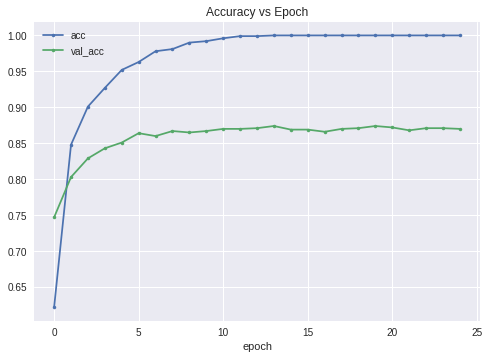

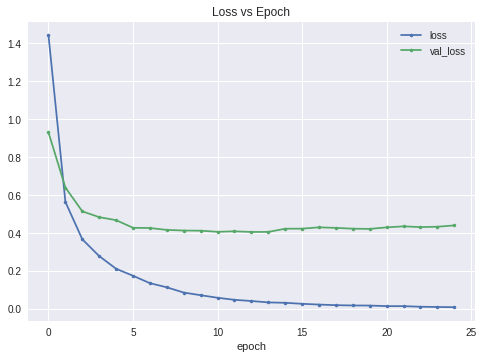

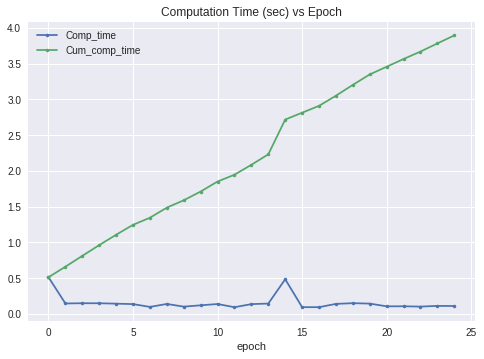

,epoch,Comp_time,Cum_comp_time,acc,loss,val_acc,val_loss
0,0,0.514335,0.514335,0.622,1.442627,0.747,0.930924
1,1,0.147509,0.661844,0.848,0.564710,0.803,0.640466
2,2,0.151006,0.812850,0.901,0.367463,0.829,0.514975
3,3,0.150533,0.963383,0.927,0.278845,0.843,0.484287
4,4,0.144896,1.108279,0.952,0.211997,0.851,0.468343
5,5,0.138690,1.246969,0.963,0.175145,0.864,0.428154
6,6,0.099452,1.346421,0.978,0.136108,0.860,0.427067
7,7,0.140976,1.487397,0.981,0.114223,0.867,0.416982
8,8,0.103140,1.590538,0.990,0.086595,0.865,0.413768
9,9,0.122007,1.712545,0.992,0.072633,0.867,0.412859


In [0]:
## Show the results
if os.path.isfile(log_file_path):
  log_df = pd.read_csv(log_file_path)
  log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
  plt.show()
  log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
  plt.show()
  log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
  plt.show()
  # pd.options.display.max_rows = 8
  display(log_df)

In [0]:
model_file_list = glob.glob('model_epoch*.hdf5')
latest_model_file = model_file_list[-1]
model = keras.models.load_model(latest_model_file)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final Model:  {}  \n  val_acc:  {:8.6f}\n  val_loss: {:8.6f}".format(latest_model_file, val_acc, val_loss))

Final Model:  model_epoch000020.hdf5  
  val_acc:  0.874000
  val_loss: 0.422369


References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint